In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels import stats
import math
from collections import namedtuple
import pickle
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from astropy.table import Table, Column

##### Define function to use for two sample z proportions tests

In [54]:
def z_prop_feature_of_interest(df, shared_column, shared_value, difference_column, difference_value):
    df1_sample = df.loc[(df[difference_column] == difference_value)]
    df2_sample = df.loc[(df[difference_column] != difference_value)]
    df1_true = df.loc[(df[difference_column] == difference_value) & (df[shared_column] == shared_value)]
    df2_true = df.loc[(df[difference_column] != difference_value) & (df[shared_column] == shared_value)]
    count = np.array([len(df1_true), len(df2_true)])
    nobs = np.array([len(df1_sample), len(df2_sample)])
    z, p = sm.stats.proportions_ztest(count, nobs, alternative = 'larger')
    return (z, p)

##### Define function to easily get proportions of values in clusters

In [55]:
def group_pct(df, feature_of_interest, cluster_col, return_groupby = False):
    group_feature_of_interest = df.groupby([cluster_col, feature_of_interest]).agg({'count' : 'sum'})
    cluster_grouped = df.groupby([cluster_col]).agg({'count' : 'sum'})
    group_feature_pct = group_feature_of_interest.div(cluster_grouped, level = cluster_col) * 100
    return (group_feature_pct.reset_index())
    if return_groupby:
        return(group_feature_pct)

# Problem

According to “Yes, Smartphone Use Is Probably Behind the Spike in Driving Deaths. So Why Isn’t More Being Done to Curb It?”, the United States witnessed a 14% spike in roadway fatalities over the 2015-2017 years (Rosenberger, 2017), and, according to “Fatal Distraction The Impact of Driver Distraction on U.S. Motor Vehicle Mortality”, the largest uptick in fatalities since the era of federally mandated seatbelts was recorded in 2014-2015 (Callaway, 2014). While data from The National Highway Traffic Safety Administration (NHTSA) suggests otherwise, many believe the increase in fatalities can in a large part be attributed to distracted driving, presumably the distraction of widely used navigation and/or communication technologies that are part of vehicles themselves, or brought into vehicles by humans.

For more than a decade,The NHTSA and other entities have prioritized studying distracted driving crash causes and prevention strategies. There already exists a wide body of experiments, observational studies, reports and campaigns, as well as legal interventions at the municipal, state and federal levels targeted at curbing use of communication technologies while driving. New research efforts contine to be made on persisting distracted driving issues.


# Client

My client is the NHTSA, also the very source of the data for this project. As was previously stated, the NHTSA is already involved at various levels on the public health issue of distracted driving crashes. This project aims to bolster their efforts in a variety of ways. 

There are reports that two of the main NHTSA datasets on U.S. crashes underestimate distracted driving, due to a lack of cohesiveness in data collection practices on distraction across the nation, as well as the difficulty of collecting the data through self reporting of the drivers involved in crashes. In 2012, the National Safety Council, separate from the NHTSA, reported estimates of phone-distracted crashes as high as 26% (Fischer, 2016), much higher than numbers from the NHTSA data suggest.

In order to interpret results and make recommendations based on analysis of a dataset, some assumptions about the dataset must be made, and there must be an established confidence in the dataset as capturing some level of truth about the phenomena in question. Known underreporting of distracted driving cases in the NHTSA GES crash dataset then, is an obstacle that the NHTSA itself, or other users will face when attempting to draw conclusions about distracted driving usings this dataset. 

This project aims to apply machine learning algorithms to the NHTSA GES dataset to identify groups  in the dataset with high levels of distracted driving, and the features that characterize these groups. Assuming that there is no pattern in the dataset or correlation amongst a set of features when it comes to the underreporting of distracted driving, and that distracted driving underreporting is, for the most part, evenly spread among the dataset, the results of the analysis will serve the NHTSA by bringing to light the key features of distracted crashes. Despite underreporting of distraction in the dataset, these archetype groups of the most distracted drivers will allow the NHTSA to accurately promote legislation, policy or safety campaigning efforts aimed specifically at these high-risk groups. 


# Dataset

The NHTSA GES dataset is a nationally representative sample, collected from police reports of crashes of different severity. The sample relies on various levels of stratification and random sampling to obtain accident reports from police jurisdictions nationwide. It should be noted that distinct reporting fields for distracted driving vary across jurisdictions, and in some cases are inexistent, in which case data must be extract from the narrative of the Police Accident Report. This is known to lead to under and over-reporting of distracted driving (Vegega, 2013)

Other datasets that might be used for this analysis are other NHTSA datasets such as the NHTSA Fatality Reporting Analysis dataset, or crash datasets at a more local scale, such as municipal or state data. Using more localized data might increase confidence in recommendations made through analyses, as recommendations will be aimed at a local scale and interpretable in the context of a smaller area of interest than, say, the national level, as is the case with the NHTSA GES dataset.

##### The dataset can be obtained directly from the NHTSA at a file transfer protocol:

ftp://ftp.nhtsa.dot.gov/GES/

##### The main user manual used for the dataset is located here:

ftp://ftp.nhtsa.dot.gov/GES/GES12/


##### Directories from the file protocol of the specific files downloaded for this analysis are:

- GES10_PCSAS
- GES11_PCSAS
- GES12_PCSAS
- GES13_PCSAS
- GES10_PCSAS
- GES2014SAS
- GES2015sas


#### __[Extracting Data From NHTSA GES Repository Years 2010-2015](https://github.com/murra667/Predicting-Distracted-Driving-Under-reporting-In-NHTSA-Distracted-Driving-Crash-Data/blob/master/Data%20Cleaning/Extract%20and%20Merge%20NHTSA%20GES%20Dataset.ipynb)__

Data from the NHTSA GES dataset is stored across dozens of file types for each individual year that contain certain dimensions of the data. For this analysis, data was pulled from the person, accident, vevent, vehicle and distract files for years 2010-2015.

This process involved first downloading the necessary files from the NHTSA file protocol. Due to differences across directory paths for the years, as well as other small details, data was manually downloaded from the protocol to save time. After downloading the data on the machine, a data container system was developed to effectively read in the appropriate file types and years and make proper joins. Joins between the accident, vevent, vehicle and distract files for the dataset were not based off of one-one relationships between rows in the data. To identify unique rows, the CASENUM and VEHNO features (case number of a crash and vehicle number of any vehicle involved in the crash) were concatenated to create a unique id. The CASENUM feature contains duplicate values across the dataset, as it corresponds to a row detailing all accident attributes associated with any driver involved in any accident. Only rows where PER_TYP (a feature providing information on any person involved in any crash) with value "1", indicating a driver were kept in the dataset. In order to still capture information on whether or not a non-motorist, such as a pedestrian or bicyclist, were involved in the crash, a separate feature was created using the appropriate values of the PER_TYP field before subsetting the data using only PER_TYP with value 1. A sample dataset of 10,000 (out of 536,020) rows of the final results of this script can be seen in the __[nhtsa_ges_extracted_sample.csv](https://github.com/murra667/Predicting-Distracted-Driving-Under-reporting-In-NHTSA-Distracted-Driving-Crash-Data/tree/master/Data)__ . All features extracted can be seen in the code of the __[script](https://github.com/murra667/Predicting-Distracted-Driving-Under-reporting-In-NHTSA-Distracted-Driving-Crash-Data/blob/master/Data%20Cleaning/Extract%20and%20Merge%20NHTSA%20GES%20Dataset.ipynb)__, however these features may or may not be relevant to the clustering analysis or final statistical analysis. For further information, refer to the section below. 

#### __[Renaming, integrating and engineering features for K-Modes Clustering](https://github.com/murra667/Predicting-Distracted-Driving-Under-reporting-In-NHTSA-Distracted-Driving-Crash-Data/blob/master/Data%20Cleaning/Clean%2C%20Rename%20and%20Engineer%20Features%20in%20NHTSA%20GES%20Dataset%20for%20K-Modes%202.ipynb)__

There was a need to integrate and rename features and their values in the dataset for clustering analysis. To begin, a list of features and their new names is provided below. Consult the GES dataset manual at for any questions about the original features and their values. 

##### "MDRDSTRD" : "distraction" 
##### "PJ" : "police jurisdiction"
##### "REGION" : "region",
##### "PER_TYP" : "person involved"
##### "AGE" : "age"
##### "SEX" : "sex"
##### "ALTRSULT" : "alcohol"
##### "DAY_WEEK" : "dow" (day of week)
##### "HOUR" : "hr"
##### "INT_HWY" : "interstate hwy"
##### "LAND_USE" : "population class"
##### "MAN_COLL" : "collision"
##### "MAX_SEV" : "injury"
##### "MINUTE" : "min"
##### "MONTH" : "month"
##### "RELJCT2" : "specific location"
##### "REL_ROAD" : "relation to road"
##### "TYP_INT" : "intersection type"
##### "WRK_ZONE" : "work zone"
##### "VNUM_LAN" : "lanes"
##### "AOI1" : "area of impact"
#####  "WEIGHT" : "weight"
##### "TRAV_SP" : "speed"
##### "VSPD_LIM" : "speed limit"
##### "YEAR": "year"
##### "ACC_TYPE" : "crash type"
##### "MAKE": "make"
##### "NUMOCCS" : "vehicle occupants"

Some variables were engineered by necessity, as the k-modes algorithm is designed for categorical features. 

#### collision: like values were integrated in the collision column in an attempt to improve the clustering outcome. Values that were integrated were collisions where the driver was driving in reverse

#### relation to road: like values were integrated int he collision column in an attempt to improve clustering, specifically values representing a crash that was outside of the road entirely

#### age: age was made categorical, breaking age groups up by 10 years and making sure to capture those above and below 24 years of age in separate groups, as domain research indicated this to be an important cutoff of difference for this feature

#### hr: hour was made categorical, breaking up times into off hours and rush hour categories, so as to better observe differences between crashes, rather than use hour-by-hour groupings

#### speed limit: speed limit was made categorically, breaking up speed limits by 10 or 15 mph increments, making sure to capture freeway and interstate speeds and residential speeds. 

#### vehicle occupants: vehicle occupants was broken up by # of occupants from 1-10, after which all occupants were grouped into one single value category

All other feature engineering took place after clustering, for purposes of inferential statistics analysis. A description of the final data input into the k-modes algorithm is detailed below. 


# __[Machine Learning With K-Modes](https://github.com/murra667/Predicting-Distracted-Driving-Under-reporting-In-NHTSA-Distracted-Driving-Crash-Data/blob/master/k_modes_machine_learning/K-Modes%20EDA%20Clustering.ipynb)__

K-modes was chosen as the machine learning algorithm to cluster the dataset, as it is intended for categorical datasets. A different approach, one-hot encode each feature, applying PCA, and implementing K-means was also considered. 

The final dataset input into the k-modes algorithm contained 14 dimensions and 535,651 rows. Below are the final inputs used in the k-modes algorithm: 

#### work zone
#### speed limit
#### relation to road
#### specific location
#### month
##### injury
#### collision
#### population class
#### interstate hwy
#### hr 
#### dow
#### sex
#### age
#### vehicle
#### occupants


# Analysis of K-Modes Clustering Results 

Below is an analysis combining EDA and inferential statistics on the results of clustering using k-modes. A sample dataset of the k-modes clustering output is available as [k_modes_manual_clusters_with_distracted_sample.csv](https://github.com/murra667/Predicting-Distracted-Driving-Under-reporting-In-NHTSA-Distracted-Driving-Crash-Data/tree/master/k_modes_machine_learning)

In [121]:
final_df = pd.read_csv("k_modes_manual_clusters_with_distracted.csv")

#### Due to the quantity of statistical tests applied to features across the dataset, a bonferroni adjustment will be made to each of the tests. First, an empty list is instantiated to store all statistical results of each two sample z proportions test.

In [91]:
statistical_tests_list = []
result = []

#### The bonferroni test is applied to the p-value result of each test stored in statistical_tests_list. The cell below is executed only after all statistical tests have been performed in the Analysis of Feature Dissimilarity Between Clusters Section

In [134]:
result = stats.multitest.multipletests([p[2] for p in statistical_tests_list], .05, 'bonferroni')

# Analysis of Feature of Dissimilarity Between Clusters 

Visualizing clusters based on the relative proportion of values each cluster contains across features is an intuitive way to visualize the data, as cluster centroids in the k-modes algorithm are determined by the most frequently ocurring value in each feature. In other words, the cluster centroids constructed in the algorithm, and examined in a table below, can themselves be identified as the tallest bar for a given feature in a given cluster in the series of figures seen below.



### K-Modes Centroids


In [7]:
with open(r'C:\Users\murra667\Documents\Springboard\Capstone_2\k_modes_machine_learning\k_modes_centroids.pickle', 'rb') as fp:
    k_modes_centroids = pickle.load(fp)

In [8]:
centroids_df = pd.DataFrame(k_modes_centroids[6], columns = ['work zone', 'speed limit',
              'relation to road', 'specific location', 'month', 'injury', 'collision',
              'population class', 'interstate hwy', 'hr', 'dow', 'sex', 'age', 'vehicle occupants'])
print ("The number of data points in each cluster:\n{}".format(final_df['6'].value_counts()))
centroids_df

The number of data points in each cluster:
0    248868
1    116951
2     47072
5     41349
4     39647
3     39581
Name: 6, dtype: int64


,work zone,speed limit,relation to road,specific location,month,injury,collision,population class,interstate hwy,hr,dow,sex,age,vehicle occupants
0,0.0,35_45,roadway,1.0,10.0,none,rear_end,3.0,0.0,afternoon,6.0,M,45_64,1
1,0.0,25_35,roadway,2.0,12.0,non_incap,angle,8.0,0.0,afternoon_rush,5.0,F,15_24,1
2,0.0,15_25,roadway,3.0,8.0,possible,not_motor_vehicle,8.0,0.0,morning_rush,2.0,M,25_34,1
3,0.0,N/R,roadway,1.0,11.0,none,not_motor_vehicle,1.0,0.0,afternoon_rush,7.0,F,25_34,2
4,0.0,45_55,roadway,3.0,6.0,none,angle,1.0,0.0,afternoon_rush,3.0,M,35_44,1
5,0.0,55_85,roadway,1.0,1.0,none,side_swipe,8.0,0.0,morning_rush,4.0,F,35_44,1


#### Cluster Imbalance
There is somewhat of an imbalance when it comes to the distribution of features in each cluster. Clusters 0 accounts for the largest number of points, followed by cluster 1. Clusters 2-5 are similar in the amount of points that they contain, each significantly less than clusters 0 and 1. 

#### K-modes Cluster Centroids

The above table displays the most frequent value for each feature for clusters 0-5, cluster label indicated by the index. Each vector represents the k-modes centroid of the cluster. As can be seen, there are some values, such as "work zone", "relation to road" and "interstate hwy" along which the clusters are most similar. In contrast, variables such as "speed limit", "month", "collision" and "dow" highlight where centroids are most dissimilar. K-modes is different from the more moderate decision making of k-means with respect to cluster belonging and distance, as it makes a strict decision for each feature: the values for a feature vector in question either match, or do not match the values for the feature vector of a centroid. This means that some of the nuances in how clusters are dissimilar cannot merely be gleaned by looking at the centroids table. Below, value counts across several variables are plotted for each cluster, to get a better idea of similarity and dissimilarity across clusters. 


### Identifying Clusters With Highest Distracted Driving Proportions

A main feature of interest for statistical analysis is the proportion of distracted driving cases in each cluster. The distracted driving binary variable was not included in the k-modes algorithm, an attempt to capture any underlying differences in distracted driving cases across clusters caused by correlations between distracted driving and other variables. The analysis seeks to identify these differences across clusters with respect to distracted driving in an attempt to discover an archetype of crashes at high risk for involving a distraction, or danger. K-modes clustering was run so as to obtain sets of 2, 3, 4, 5 and 6 clusters. The analysis chose to focus on the output set of six clusters, as it seemed to best capture differences in proportions of distracted/non-distracted driving and some other features across clusters. Below are displayed each cluster and their proportion of distracted driving crashes, as well as the exact percentage of 0 (not distracted) and 1 (distracted) labels for clusters 0-5. 

Distracted Cases 55431
Non-Distracted Cases 478037
    6  distracted_binary      count
0   0                  0  89.626629
1   0                  1  10.373371
2   1                  0  89.721336
3   1                  1  10.278664
4   2                  0  88.428365
5   2                  1  11.571635
6   3                  0  88.469215
7   3                  1  11.530785
8   4                  0  89.409035
9   4                  1  10.590965
10  5                  0  91.816005
11  5                  1   8.183995


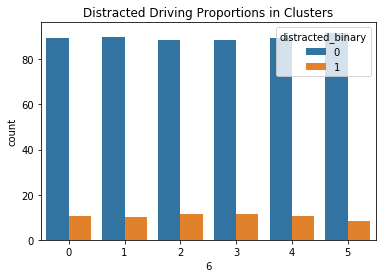

In [9]:
distracted = final_df.loc[final_df['distracted_binary'] == 1]
non_distracted = final_df.loc[final_df['distracted_binary'] == 0]
print ("Distracted Cases {}\nNon-Distracted Cases {}".format(len(distracted), len(non_distracted)))
print (group_pct(final_df, 'distracted_binary', "6", return_groupby = True))
df_groupby = group_pct(final_df, 'distracted_binary', "6")
plt.figure()
plt.title('Distracted Driving Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='distracted_binary', data=df_groupby)

Evaluating significant differences in proportions of distracted vs. non-distracted driving cases in each cluster involved a series of two proportions z tests for the distracted/non-distracted proportion of each cluster compared to the distracted/non-distracted proportion for the rest of the dataset. Results from the tests below will be used to identify clusters of interest regarding the archetypes of crashes at high risk for involving distracted driving and danger. 

#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions Across Clusters

##### Ho: For clusters 0-5, there is not a difference between the proportion of distracted driving crashes in cluster x compared to the proportion of distracted driving crashes in the rest of the clusters combined

##### Ha: For clusters 0-5, the proportion of distracted driving crashes in cluster x is greater than the proportion of distracted driving crashes in the rest of the clusters combined.

##### alpha: .05

In [92]:
for i in range(0,6):
    z, p = z_prop_feature_of_interest(final_df, "distracted_binary", 1, "6", i)
    statistical_tests_list.append((i, z, p, .05))

In [126]:
for cluster, reject_null in zip(range(0,6), result[0][0:6]):
    print ("For cluster {}, reject Ho is {}\nAdjusted alpha level for the test was {}".format(cluster, reject_null, result[3]))    

For cluster 0, reject Ho is False
Adjusted alpha level for the test was 0.0015151515151515152
For cluster 1, reject Ho is False
Adjusted alpha level for the test was 0.0015151515151515152
For cluster 2, reject Ho is True
Adjusted alpha level for the test was 0.0015151515151515152
For cluster 3, reject Ho is True
Adjusted alpha level for the test was 0.0015151515151515152
For cluster 4, reject Ho is False
Adjusted alpha level for the test was 0.0015151515151515152
For cluster 5, reject Ho is False
Adjusted alpha level for the test was 0.0015151515151515152


The result of the test indicates clusters 2 and 3 as clusters of interest for the analysis 

### Age Categories Proportions Across Clusters

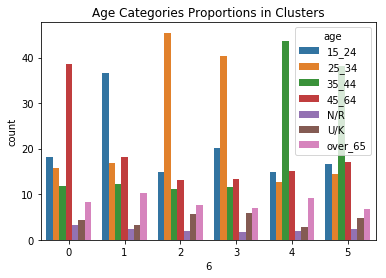

In [11]:
df_groupby = group_pct(final_df, 'age', "6")
plt.figure()
plt.title('Age Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='age', data=df_groupby)

It's notable that age for both clusters 2 and 3 are byfar, nearly majority in the 25-34 year old range. However, general domain knowledge suggests that teenagers are at the highest risk for distracted driving. This prompts a comparison of the proportions of 25-34 year olds involved in distracted driving cases and 15-24 year olds involved in distracted driving cases. 


#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions of 15-24 year olds and 25-34 year olds 

##### Ho: There is not a difference between the proportion of distracted driving crashes for 15-24 year olds and distracted driving crashes for 25-34 year olds.

##### Ha:  The proportion of distracted driving crashes for 25-34 year olds is greater than that of 15-24 year olds.

##### alpha: .05

In [93]:
age_subset = final_df.loc[(final_df['age'] == "15_24") | (final_df['age'] == "25_34")] 
z, p = z_prop_feature_of_interest(age_subset, "distracted_binary", 1, "age", "25_34")
statistical_tests_list.append(('age', z, p, .05))

In [106]:
print ("Comparing {} groups 15-24 and 25-34, reject Ho is {}\nAdjusted alpha level for the test was".format(statistical_tests_list[6][0], result[0][6]), result[3])

Comparing age groups 15-24 and 25-34, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852


### DOW (day of week) Proportions Across Clusters

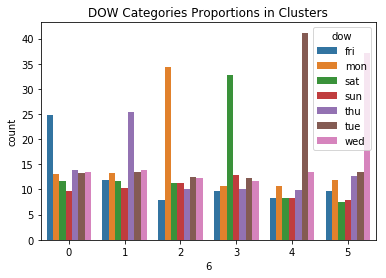

In [13]:
df_groupby = group_pct(final_df, 'dow', "6")
plt.figure()
plt.title('DOW Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='dow', data=df_groupby)

The dow (day of week) feature shows Monday as the most prevalant day for crash incidents in cluster 2, and saturday as the most prevelant day for crash incidents in cluster 3. Results of the K-modes algorithm are such that each cluster has a unique day as the most commonly occuring value for the dow feature. A statistical test is performed to see if the proportion of distracted crashes on Monday and Saturday is higher than the proportion of distracted crashes for the rest of the dataset. 

#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions on Saturdays or Mondays and all other days of the week 

##### Ho: For subsets of distracted crashes on monday or saturday , there is no difference between the proportion of distracted driving crashes for subset (x) and the proportion of distracted crashes for all other days of the week.

##### Ha:  For subsets of distracted crashes on monday or saturday, the proportion of  of distracted driving crashes for subset (x) is greater than the proportion of distracted crashes for all other days of the week.


##### alpha: .05


In [94]:
final_df['saturday'] = 0
final_df['monday'] = 0 
input_columns_dow = ['saturday', 'monday']
final_df.loc[(final_df['dow'] == 'sat'), 'saturday'] = 1
final_df.loc[(final_df['dow'] == 'mon'), 'monday'] = 1
for column_dow in input_columns_dow:
    z, p = z_prop_feature_of_interest(final_df, "distracted_binary", 1, column_dow, 1)
    statistical_tests_list.append((column_dow, z, p, .05))

In [107]:
for column_dow, reject_null_dow in zip(input_columns_dow, result[0][7:9]):
    print ("For binary column {}, reject Ho is {}\nAdjusted alpha level for the test was {}".format(column_dow, reject_null_dow, result[3]))    

For binary column saturday, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852
For binary column monday, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852


### Hr Categories Proportions Across Clusters 

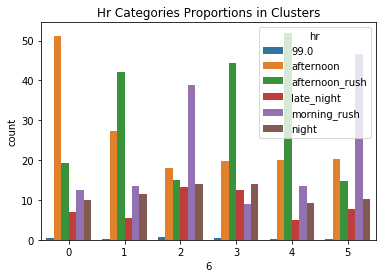

In [15]:
df_groupby = group_pct(final_df, 'hr', "6")
plt.figure()
plt.title('Hr Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='hr', data=df_groupby)

A near-majority of crashes in cluster 2 happen during the morning rush hour, between hours 6 and 10, and for cluster 3, the afternoon rush hour, between hours 16 and 20. A statistical test is conducted to compare proportions of distracted driving crashes during morning or afternoon rush hours, and oustide of morning or afternoon rush hours 

#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions In Morning Rush and Afternoon Rush Accidents

##### Ho: For subsets of distracted crashes during afternoon rush or morning rush, there is no difference between the proportion of distracted driving crashes for subset (x) compared to the proportion of distracted driving crashes at all other times of day

##### Ha:  For subsets of distracted crashes during afternoon rush or morning rush, the proportion of  of distracted driving crashes for subset (x) is greater than the proportion of distracted crashes at all other times of day

##### alpha: .05


In [95]:
final_df['afternoon_rush'] = 0
final_df['morning_rush'] = 0 
input_columns_hr = ['afternoon_rush', 'morning_rush']
final_df.loc[(final_df['hr'] == 'afternoon_rush'), 'afternoon_rush'] = 1
final_df.loc[(final_df['hr'] == 'morning_rush'), 'morning_rush'] = 1
for column_hr in input_columns_hr:
    z, p = z_prop_feature_of_interest(final_df, "distracted_binary", 1, column_hr, 1)
    statistical_tests_list.append((column_hr, z, p, .05))

In [108]:
for column_hr, reject_null_hr in zip(input_columns_hr, result[0][9:11]):
    print ("For binary column {}, reject Ho is {}\nAdjusted alpha level for the test was {}".format(column_hr, reject_null, result[3]))    

For binary column afternoon_rush, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852
For binary column morning_rush, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852


### Speed Limit Class Categories Proportions Across Clusters

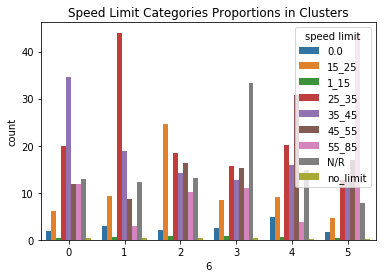

In [18]:
df_groupby = group_pct(final_df, 'speed limit', "6")
plt.figure()
plt.title('Speed Limit Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='speed limit', data=df_groupby)

Clusters 2 and 3 not only show dissimilarity amongst each other (cluster 2 with speed limit 15-20 as the highest proportion, and cluster 3 with N/R as the highest proportion), but they also show distinction from other clusters in their largest proportion values. On a separate note, an interesting point is cluster 5, which had the largest proportion of interstate hwy accidents byfar among other clusters (seen in the cell below), and also the highest proportion byfar at speeds between 55-85 miles per hour, showing that k-modes was able to make the correct decision for this cluster.


### Interstate Hwy Categories Proportions Across Clusters

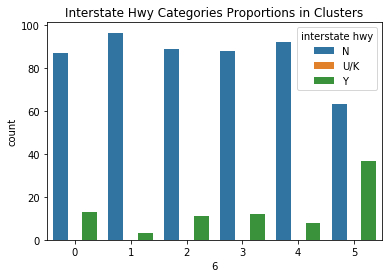

In [19]:
df_groupby = group_pct(final_df, 'interstate hwy', "6")
plt.figure()
plt.title('Interstate Hwy Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='interstate hwy', data=df_groupby)

See cluster 5 with the highest proportion of interstate highway crashes above, sensical when compared with the majority speed limit of this crash type 55-85.

A statistical test is performed to determine if the proportion of distracted driving cases in 15-25 mph speed limit zones is greater than distracted driving cases outside of 15-25 mph speed limit zones. 


#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions of crashes in 15-25 mph zones vs. distracted crashes in all other zones.

##### Ho: There is not a difference between the proportion of distracted driving crashes in 15-25 mph zones and the proportion of distracted driving crashes in all other zones

##### Ha:  The proportion of distracted driving crashes in 15-25 mph zones is greater than that of distracted crashes in all other zones

##### alpha: .05

In [96]:
z, p = z_prop_feature_of_interest(final_df, "distracted_binary", 1, "speed limit", "15_25")
statistical_tests_list.append(('speed limit', z, p, .05))

In [109]:
print ("Comparing {} distracted crashes in and outside of 15-25 mph zones, reject Ho is {}\nAdjusted alpha level for the test was {}".format(statistical_tests_list[11][0], result[0][11], result[3]))

Comparing speed limit distracted crashes in and outside of 15-25 mph zones, reject Ho is True
Adjusted alpha level for the test was 0.001851851851851852


### Population Class Categories Proportions Across Clusters 

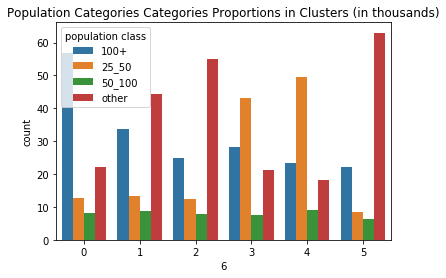

In [21]:
df_groupby = group_pct(final_df, 'population class', "6")
plt.figure()
plt.title('Population Categories Categories Proportions in Clusters (in thousands)')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='population class', data=df_groupby)

The majority value of population class for cluster 2 is "other", and for cluster 3,  a near majority in population values of 25,000 - 50,000 people. The population class feature is interesting in that half of the clusters have a majority of population values of "other" (presumed to mean less than 25,000-50,000 people according to the NHTSA GES dataset documentation. To contextualize the spread of data points across the clusters, cluster 0 has the largest number of data points and is the only cluster with a majority of crashes occuring in areas with more then 100,000 people. Intuitively, this can be interpreted as more crashes occuring where there are more people. In line with other interpretations about the cluster 5 representing highway accidents, this cluster contains byfar a majority of crashes happening in areas with populations below 25,000, where interstate hwy travel would occur. 


#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions In Populations Between 25,000-50,000 and less than 25, 000

##### Ho: For subsets of distracted crashes with populations less than 25,000 or 25,000-50,000, there is no difference between the proportion of distracted driving crashes for subset (x) and the proportion of distracted crashes in all other population classes combined

##### Ha:  For subsets of distracted crashes with populations less than 25,000 or 25,000-50,000, the proportion of  of distracted driving crashes for subset (x) is greater than the proportion of distracted crashes in all other population classes combined


##### alpha: .05

In [97]:
final_df['population_other'] = 0
final_df['population_25_50'] = 0 
input_columns_pop = ['population_other', 'population_25_50']
final_df.loc[(final_df['population class'] == 'other'), 'population_other'] = 1
final_df.loc[(final_df['population class'] == '25_50'), 'population_25_50'] = 1
for column_pop in input_columns_pop:
    z, p = z_prop_feature_of_interest(final_df, "distracted_binary", 1, column_pop, 1)
    statistical_tests_list.append((column_pop, z, p, .05))

In [110]:
for column, reject_null in zip(input_columns_pop, result[0][12:14]):
    print ("For binary column {}, reject Ho is {}\nAdjusted alpha level for the test was {}".format(column, reject_null, result[3]))    

For binary column population_other, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852
For binary column population_25_50, reject Ho is True
Adjusted alpha level for the test was 0.001851851851851852


### Collision Categories Proportions Across Clusters

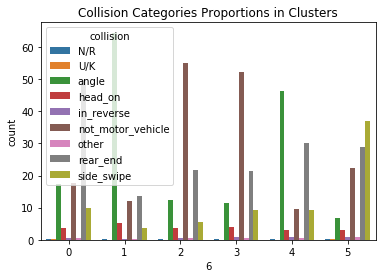

In [23]:
df_groupby = group_pct(final_df, 'collision', "6")
plt.figure()
plt.title('Collision Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='collision', data=df_groupby)

#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions of collisions with non-motor vehicle vs. distracted crashes without collisions with non-motor vehicle

##### Ho: There is not a difference between the proportion of distracted driving crashes with non-motor vehicles and distracted crashes of all other collision types

##### Ha:  The proportion of distracted driving crashes with non-motor vehicles is greater than the proportion of distracted crashes of all other collision types.

##### alpha: .05

Clusters 2 and 3, different from all other clusters share in having a majority of collisions not with a motor vehicle. This indicates that the driver first crashed into an object. A statistical test is performed between distracted crashes where the collision is first with a non-motor vehicle compared with non-distracted crashes where the collision is first with a non-motor vehicle.


In [98]:
z, p = z_prop_feature_of_interest(final_df, "distracted_binary", 1, "collision", "not_motor_vehicle")
statistical_tests_list.append(('collision', z, p, .05))

In [111]:
print ("Comparing {} proportions of distracted crashes with non motor vehicles to distracted crashes of other collision types,\n reject Ho is {}\nAdjusted alpha level for the test was {}".format(statistical_tests_list[14][0], result[0][14], result[3]))

Comparing collision proportions of distracted crashes with non motor vehicles to distracted crashes of other collision types,
 reject Ho is True
Adjusted alpha level for the test was 0.001851851851851852


### Proportions of Crashes Involving Non-motorists Across Clusters

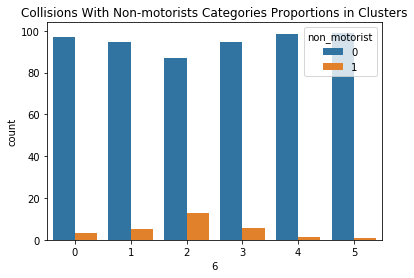

In [25]:
df_groupby = group_pct(final_df, 'non_motorist', "6")
plt.figure()
plt.title('Collisions With Non-motorists Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='non_motorist', data=df_groupby)

The proportion of crashes involving non-motorists for cluster 3, and especially cluster 3, is visibly greater than the other clusters. This binary feature will have some overlap with the collision feature for collision types of not_motor vehicles, though it will not encompass this variable entirely. For example, as was previously described, "non_motor_vehicles" values in the collision feature may indiciate that the crash involved the driver and an object, not necessarily a bicyclist or a pedestrian, whereas the "non_motorists" feature indicates collisions specifically with bicyclists or pedestrians. A statistical test is performed to compare the proportion of distracted driving crashes involving non-motorists of cluster 2, to the rest of the dataset. 

#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions from cluster 2 of collisions with non-motorists to distracted crashes with non-motor vehicles from all other clusters

##### Ho: There is not a difference between the proportion of distracted driving crashes from cluster 2 with non-motor vehicles and distracted driving crashes with non-motor vehicles from all other clusters

##### Ha:  The proportion of distracted driving crashes with non-motor vehicles is greater in cluster 2 than the proportion of distracted driving crashes with non-motor vehicles in all other clusters. 

##### alpha: .05

In [99]:
final_df['distracted_collision_non_motorist'] = 0 
final_df.loc[(final_df['non_motorist'] == 1) & (final_df['distracted_binary'] == 1), 'distracted_collision_non_motorist'] = 1
z, p = z_prop_feature_of_interest(final_df, "distracted_collision_non_motorist", 1, "6", 2)
statistical_tests_list.append(('distracted collision non motorist cluster 2', z, p, .05))

In [112]:
print ("Comparing proportions of distracted crashes with non motorists from cluster 2 to\n the proportion across the same variable to all other clusters, reject Ho is {}\nAdjusted alpha level for the test was {}".format(result[0][15], result[3]))

Comparing proportions of distracted crashes with non motorists from cluster 2 to
 the proportion across the same variable to all other clusters, reject Ho is True
Adjusted alpha level for the test was 0.001851851851851852


### Injury Categories Proportions Across Clusters Variable Bar Chart 

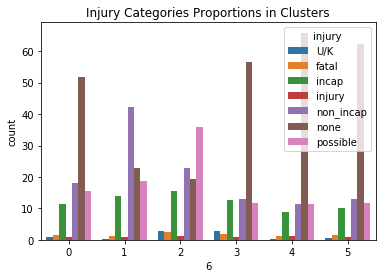

In [27]:
df_groupby = group_pct(final_df, 'injury', "6")
plt.figure()
plt.title('Injury Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='injury', data=df_groupby)

For cluster 3, the majority of injuries were none, whereas cluster 2 not only has the "possible" injury category as a majority value, but also has the largest proportion for this value among all clusters. Cluster 2 has the largest proportion of incapacitating injuries and fatal injuries, and cluster 3, one of the highest proportions of incapacitating injuries, and the second-highest proportion of fatal injuries. A statistical test is performed for all clusters in the dataset to examine for which the proportion of fatal and incapacitating crashes, if any, is higher than that of the rest of the dataset.  

#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions

##### Ho: For clusters 0-5, there is not a difference between the proportion of crashes in cluster x involving a fatality or incapacitation compared to the proportion of crashes from this attribute subset in all other clusters.

##### Ha: For clusters 0-5, the proportion of crashes in cluster x involving a fatality or incapacitation is greater than the proportion of crashes from this attribute subset in all other clusters 
##### alpha: .05

In [100]:
final_df['fatal_incap'] = 0
final_df.loc[(final_df['injury'] == "fatal") | (final_df['injury'] == "incap"), 'fatal_incap'] = 1
for i in range(2,4):
    z, p = z_prop_feature_of_interest(final_df, "fatal_incap", 1, "6", i)
    statistical_tests_list.append((i, z, p, .05))

In [113]:
for cluster, reject_null in zip(range(2,4), result[0][16:18]):
    print ("For cluster {}, reject Ho is {}\nAdjusted alpha level for the test was {}".format(cluster, reject_null, result[3])) 

For cluster 2, reject Ho is True
Adjusted alpha level for the test was 0.001851851851851852
For cluster 3, reject Ho is True
Adjusted alpha level for the test was 0.001851851851851852


### Month Categories Proportions Across Clusters

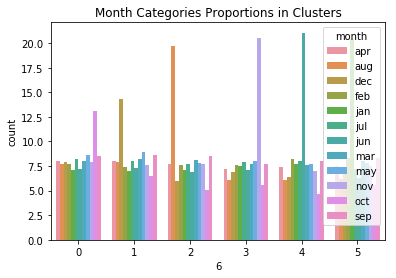

In [29]:
df_groupby = group_pct(final_df, 'month', "6")
plt.figure()
plt.title('Month Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='month', data=df_groupby)

The k-modes algorithm brought out distinction in 'month' values across all clusters. While the month of august leads cluster 2, and novemeber leads cluster 3 byfar, their proportions hover around 20% of the share.  A statistical test is performed to compare distracted driving crashes occuring in August or November with distracted driving crashes ocurring in any other month 


#### Two Sample Z Proportions to Test Difference in Distracted Driving Proportions in August or November Compared to Distracted Driving Proportions in all other months.

##### Ho: For subsets of distracted crashes occuring in august or november, there is no difference between the proportion of distracted driving crashes for subset (x) compared to the proportion of distracted crashes in all other months combined.

##### Ha:  For subsets of distracted crashes occuring in august or november, the proportion of  of distracted driving crashes for subset (x) is greater than the proportion of distracted crashes in all other months combined


##### alpha: .05

In [101]:
final_df['august'] = 0
final_df['november'] = 0 
input_columns_mo = ['august', 'november']
final_df.loc[(final_df['month'] == 'aug'), 'august'] = 1
final_df.loc[(final_df['month'] == 'nov'), 'november'] = 1
for column_mo in input_columns_mo:
    z, p = z_prop_feature_of_interest(final_df, "distracted_binary", 1, column_mo, 1)
    statistical_tests_list.append((column_mo, z, p, .05))

In [114]:
for column_mo, reject_null_mo in zip(input_columns_mo, result[0][18:20]):
    print ("For binary column {}, reject Ho is {}\nAdjusted alpha level for the test was {}".format(column_mo, reject_null_mo, result[3]))    

For binary column august, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852
For binary column november, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852


### Vehicle Occupants Categories Proportions Across Clusters

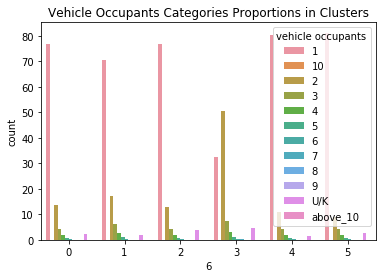

In [31]:
df_groupby = group_pct(final_df, 'vehicle occupants', "6")
plt.figure()
plt.title('Vehicle Occupants Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='vehicle occupants', data=df_groupby)

All clusters for vehicle occupants show an overwhelming majority of 1 vehicle occupant (meaning just the driver) whereas cluster 3 has a majority of 2 occupants. This might suggest that occupants were the distraction type for many of the distracted driving crashes in cluster 3. A statistical test is performed to test this hunch

#### Two Sample Z Proportions to Test Difference Distracted Value Types of Cluster 3

##### Ho: In cluster 3, there is not a difference between the proportion of distracted driving crashes caused by another passenger vs. the proportion of distracted driving crashes caused by another distraction

##### Ha:  In cluster 3, the proportion of distracted driving crashes caused by another passenger is larger than the proportion of distracted driving crashes caused by another distraction

##### alpha: .05

In [102]:
z, p = z_prop_feature_of_interest(final_df, "6", 3 , "distraction", 3)
statistical_tests_list.append((i, z, p, .05))

In [115]:
print ("Comparing proportions of distracted crashes by a vehicle occupant vs. other distraction types, reject Ho is {}\nAdjusted alpha level for the test was {}".format(result[0][20], result[3]))

Comparing proportions of distracted crashes by a vehicle occupant vs. other distraction types, reject Ho is True
Adjusted alpha level for the test was 0.001851851851851852


### Region Categories Proportions Across Clusters

#### Name region values, which was left out of both data cleaning scripts

In [33]:
final_df['region'] = final_df['region'].astype(str)
final_df.loc[final_df['region'] == "1.0", 'region'] = 'northeast'
final_df.loc[final_df['region'] == "2.0", 'region'] = 'midwest'
final_df.loc[final_df['region'] == "3.0", 'region'] = 'south'
final_df.loc[final_df['region'] == "4.0", 'region'] = 'west'

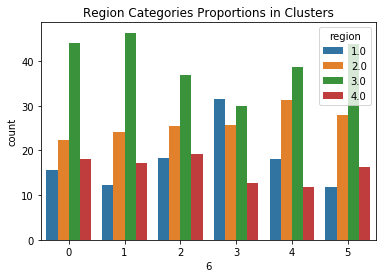

In [89]:
df_groupby = group_pct(final_df, 'region', "6")
plt.figure()
plt.title('Region Categories Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='region', data=df_groupby)

##### Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT)
##### Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS)
##### South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)
##### West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI)

Cluser 3 is distinct from other clusters along the region feature. The largest proportion of crashes along the region feature for cluster 3 is northeast, whereas for all other clusters the largest proportion is the south. It is well known in the domain of distracted driving that the southern states tend to have more lax laws and policies when it comes to distracted driving, and that the west coast tends to be more progressive in this area. This is reflected almost unanimously among the proportions of region values across clusters. 


### Phone Distraction vs. Other Distractions Across Clusters

C:\Users\murra667\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\murra667\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


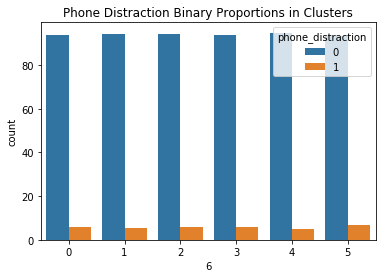

In [122]:
only_distracted = final_df.loc[final_df['distraction'] != 0]
only_distracted['phone_distraction'] = 0
only_distracted.loc[(only_distracted['distraction'] == 5) | (only_distracted['distraction'] == 6) | (only_distracted['distraction'] == 10) | (only_distracted['distraction'] == 15), "phone_distraction"] = 1
df_groupby = group_pct(only_distracted, 'phone_distraction', "6")
plt.figure()
plt.title('Phone Distraction Binary Proportions in Clusters')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
sns.barplot(x="6", y="count", hue='phone_distraction', data=df_groupby)

In [132]:
for i in range(0,6):
    z, p = z_prop_feature_of_interest(only_distracted, "phone_distraction", 1, "6", i)
    statistical_tests_list.append((i, z, p, .05))

In [137]:
for cluster, reject_null in zip(range(0,6), result[0][21:27]):
    print ("For cluster {}, reject Ho is {}\nAdjusted alpha level for the test was {}".format(cluster, reject_null, result[3]))    

For cluster 0, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852
For cluster 1, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852
For cluster 2, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852
For cluster 3, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852
For cluster 4, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852
For cluster 5, reject Ho is False
Adjusted alpha level for the test was 0.001851851851851852


In [141]:
statistical_tests_list

[(0, -0.387637695894857, 0.6508579156639879, 0.05),
 (1, -1.4208771682902352, 0.9223237642087638, 0.05),
 (2, 8.793704110727196, 7.235417817412099e-19, 0.05),
 (3, 7.725498263571, 5.570833017424802e-15, 0.05),
 (4, 1.358331116176007, 0.08717932050909344, 0.05),
 (5, -15.310698881067854, 1.0, 0.05),
 ('age', -21.41946600949577, 1.0, 0.05),
 ('saturday', -1.7026958553504186, 0.9556874995430831, 0.05),
 ('monday', -0.3986890135929769, 0.6549388179903946, 0.05),
 ('afternoon_rush', -0.02473793082354039, 0.5098680000460867, 0.05),
 ('morning_rush', -2.253154085467501, 0.9878752823698403, 0.05),
 ('speed limit', 16.888367887843106, 2.739900147090031e-64, 0.05),
 ('population_other', -22.565907811569268, 1.0, 0.05),
 ('population_25_50', 30.601220712745885, 5.895156748092883e-206, 0.05),
 ('collision', 20.836566871668136, 1.0090116215329293e-96, 0.05),
 ('distracted collision non motorist cluster 2', 41.20686327028551, 0.0, 0.05),
 (2, 28.148603533342303, 1.2462902554861478e-174, 0.05),
 (3, 

In [143]:
print ("While all results for this test indicate False, the p-value of cluster 5 is {}, just .001 above the alpha threshold. Bonferroni adjustments are known for causing type II errors, so the null hypothesis can probably be rejected in this case, and cluster 5 flagged as a particularly distracted cluster of drivers".format(statistical_tests_list[26][2]))

While all results for this test indicate False, the p-value of cluster 5 is 0.002492342018507019, just .001 above the alpha threshold. Bonferroni adjustments are known for causing type II errors, so the null hypothesis can probably be rejected in this case, and cluster 5 flagged as a particularly distracted cluster of drivers


## Conclusion 

For the problem at hand, k-modes was valuable in identifying some of the trends underlying crashes between the 2010 and 2015 years in the NHTSA GES dataset. In addition, k-modes was able to identify clusters 2 and 3 as having a statistically significant higher proportion of crashes involving distracted driving. Identifying these clusters then allowed careful examination of their centroids, as well as the value proportions making up each cluster along certain features. 

#### Assumptions

Before highlighting some of the results of statistical significance and their potential interpretation for action that might be taken by the NHTSA, there are some assumptions and precautions that should be noted. To begin, this dataset is assumed to be a representative sample of crashes nation-wide. The details on the sampling method can be obtained by examining the NHTSA GES dataset manual and the documentation on data collection for years 2010-2015. A precaution that should be taking when drawing actionable insights from the dataset is the bias injected into the model by handpicking features on which to run K-modes, given domain knowledge about important features in distracted driving crashes in the United States. Another precaution that might be taken is specifically with the way that the K-modes algorithm characterizes input data. When evaluating clusters and their contents, it should be noted that k-modes makes a strict decision with regards to plurality voting of feature values (the mode) when binning data into clusters. This means that data points across two or more clusters may only be slightly different in their values. However, this analysis should be robust in that it considers both the clusters alongside inferential statistics performed on the dataset as a whole. 

#### Discussion of Inferential Statistics Results 

When it came to identifying the characteristics of distracted driving and the k-modes clusters with respect to time, there were not statistically significant results. While the clusters of interest, 2 and 3 did show distinction in their value proportions across "month", "dow" and "hr" features, these k-modes decisions were not reflected in statistically significant differences in distracted driving crash proportions across these feature values. 

There seemed to be a common thread when it came to features such as "collision", the binary "non_motorist", "injury", and perhaps "speed limit" columns. To begin, that the proportion of distracted driving crashes not involving another motor vehicle is greater than the proportion of all other collision types, and that these are the largest value counts for clusters 2 and 3 indicate a few things. First of all, it reinforces that the k-modes algorithm was able to identify this pattern, as the majority of "collision" cases in the most distracted clusters by proportion, 2 and 3, are with non-motor vehicles. There are a few explanations for the co-occurence of incidents of distraction and collisions with non-motor vehicles. A few scenarios come to mind. In the first scenario the driver comes out of their distraction, attempts to make a correction, and hits something. In the second scenario, the driver hits an object before having a chance to correct because they are distracted. In the third scenario the object that a driver hits is a pedestrian or bicyclist, which are known to be harder to see than vehicles, and would be even harder to identify while absorbed by a distraction. This last scenario indicates how clusters 2 and 3 may present a certain level of danger unseen in other clusters. An attempt to gauge this danger level was made investigating distracted crashes where pedestrian or bicyclists are the non-motorist object hit. Results from this test revealed cluster 3 and cluster 2 in particular as having a greater share of these types of accidents. A case is made further for clusters 2 and 3 as particularly dangerous, both showing statistical significance in their proportions of injury type as lethal or incapacitating when compared to the proportion of clusters combined. More focus might be made on cluster 2 however, as the majority of cluster 3 injuries were none. On the other hand, a near majority of cluster 2 injuries were "possible". The ambiguity of this category, and the data that goes into it in police reporting should be further investigated, but it is curious that cluster 2 stands out as a cluster containing the greatest proportion of this value type. 

"Speed limit" might be tied into the above assessment of the trends in clusters 2 and 3 with respect to "collision" and "injury" features in that cluster 3 contains the greatest proportion of 15-25 mph zones, which show statistical significance with respect to the proportion of distracted crashes occurring in these zones.  First of all, drivers may pay less attention (day dream) or feel more comfortable going at a lower speed. Secondly, there may be more risk of hitting pedestrians and bicyclists in 15-25 mph zones, where these road users likely travel. This second explanation can be backed up by statistical significance obtained in the proportion of collisions with pedestrians or bicyclists that occur while distracted. Another important feature to highlight that stands out in cluster 3 is the number of occupants that were in the vehicle during the crash. Cluster 3 has the largest proportion of crashes where there were two occupants, and shows statistical significance in this proportion when compared to the rest of the clusters.

Some intuitive conclusions were able to be drawn when examining the "speed limit", "interestate hwy", "collision" and "population class" variables, most notably with cluster 5. The speed limit for cluster 5, 55-85 mph, paired with it's proportion of on interstate crashes (the highest of all clusters) points to cluster 5 as interstate crashes. In addition, this cluster contains the highest cluster proportion of "population class" values of "other", indicating populations near crash sites of less than 25,000. And, the most common collision type for cluster 5 is a side swipe. This information, when paired with a statistically significant result for cluster 5 with respect to its proportion of cell phone distraction-related crashes point to some actions that can be taken. 


an aggresive media campaign should be targeted at cluster 2 characteristics. 
### Actionable Insights

Action that can be taken as a result of this analysis might occur at the level of NHTSA or other bodies using the information to shape their efforts lobbying for policy, or influencing and creating safety campaigns. The results of this analysis indicate a few approaches to what specific of policy lobbying to focus on, and what information might be included in safety campaigns. 

The k-modes algorithm was able to identify two archetypes (clusters 2 and 3) of where distracted driving crashes occur with more frequency. The characteristics of these clusters, in addition to the statistical tests that they prompted, can be used to shape the where, who and what of actions to take. 

#### Where:

Cluster 5 identified a group of crashes involving distracted driving crashes occuring on interstate roads. Statistical significance for this group with respect to phone-related distraction point to an opportunity for the NHTSA to advocate for a federal policy against phone use on federal roads such as interstates, or a nation-wide policy against phone use on roads 55-85 mph. Steps may also be taken towards educational efforts with respect to cluster 5. Signs and/or billboards can be placed on the interstate warning against cell phones and distracted driving. Police enforcement efforts can also be ramped up on these roads, doing further research on hot spots for crashes, and, if notable, hot-spot areas or regions for distracted driving crashes.

Cluster 3 points to crashes that occur as a result of distraction by an occupant, and the speed limit in which these accidents occur is not reported. These incidents frequently involve collisions with non-motor vehicles, such as objects, pedestrians or bicyclists.  Educational campaigns toward drivers in this cluster should emphasize the danger of being distracted by other occupants.  As cluster 3 does have a larger proportion of its crashes in the Northeast region of the U.S, this may be a place of interest for these interventions.

Cluster 2 points to distracted collisions that frequently involve pedestrians or bicyclists, and frequently involve death or incapacitation. These crashes occur where the population is less than 25,000, and frequently on roads 15-25 mph. Educatinoal campaigns for this group should emphasize the danger of distracted driving even at low speeds. Collision hot-spots with pedestrians or bicyclists on 15-25 mph roads should be identified, and flashing light crosswalks or protected bike lanes installed. Enforcement efforts should be made at identified distracted crash hot spots. Other enforcement effors may include a double fine for distracted driving or speeding in identified hot spot zones. 

Because clusters 2 and 3 did not necessarily point to phone distraction as an issue, yet crashes in these groups seemed, by proportion, more lethal and involving non-motorists, educational efforts should also emphasize the danger of using built-in car technologies, or the danger of non-phone distractions. 


#### Who



With respect to results obtained on cluster 5, educational efforts may also be made to target 35-45 year olds, the largest age group in this cluster. This could be through ads targeted at this age group and strategically placed through the media mediums that it uses most. 

Educational efforts regarding interventions for clusters 2 and 3 should target the 25-34 age group, as this was the age group most represented in these clusters. For cluster 2, educational efforts may be targeted at people in rural areas, as this is likely where the crashes are occuring, given that the speed limit is 15-25 mph.




conclusion is two-fold: identify cluster 2 as lethal, and a  prototype of media campaigning, and without much domain knowledge, see where areas of statistical significance in the dataset are 

emphasizing that even non-cell phone distractions, such as objects in cars, or even technology in cars, which may not have the same stigma as texting and driving, can be dangerous. 

Age 25-34 is not greater than another known age group 15-24. This is in line with what domain research indicates. However, it is interesting that it is 25-34 year olds who make up both cluster 2 and 3. If performed, a proportions test might indicate that 25-34 year olds have a higher proportion of distracted driving than the rest of the population

highlight the importance of focusing on the road, even while driving at low speeds with somebody else in the car. 

An action the NHTSA might take given the clustering results would be to push education efforts that target 25-34 year olds. As cluster 3 points to distraction by other people in the car. Outreach efforts especially should be made with regards to this in areas with populations 25-50 thousand, or road sides along the freeway within a certain distance buffer reminding people. Motor vehicles is true for 

While domain research was done on some of the important features in distracted driving, k-modes was used to attempt to identify groups that are of special interest with respect to distracted driving, and to tease out from the surface some of the main features that have a relationship with the clusters, and therefore distracted driving. EDA techniques to establish relationships between variables, such as scatterplots, are not possible with categorical variables. 


# Attempt K-means

In an effort to compare the performance of k-means to that of k-modes on the dataset, k-means was run with some of the continuous features in the dataset such as "vehicle occupants", "age", "speed limit", the binary "non_motorist" variable and a rating of "injury" numerically. Difference across the clusters was more subtle than with k-modes. 

In [146]:
from sklearn.cluster import KMeans
import numpy as np

In [147]:
k_means_df = pd.read_csv("nhtsa_ges_extracted.csv")
df = pd.read_csv(r"C:\Users\murra667\Documents\Springboard\Capstone_2\After 2010\2010_2015_GES_k_modes_input.csv")
k_means_df = k_means_df.rename( columns = {"MDRDSTRD" : "distraction", "PJ" : "police jurisdiction", "REGION" : "region",
        "PER_TYP" : "person involved", "AGE" : "age", "SEX" : "sex", "ALTRSULT" : "alcohol", "DAY_WEEK" : "dow", "HOUR" : "hr", "INT_HWY" : "interstate hwy", "LAND_USE" : "population class", "MAN_COLL" : "collision",
        "MAX_SEV" : "injury", "MINUTE" : "min", "MONTH" : "month", "RELJCT2" : "specific location", "REL_ROAD" : "relation to road", "TYP_INT" : "intersection type", "WRK_ZONE" : "work zone", "VNUM_LAN" : "lanes", "AOI1" : "area of impact",
        "WEIGHT" : "weight", "TRAV_SP" : "speed", "VSPD_LIM" : "speed limit", "YEAR": "year", "ACC_TYPE" : "crash type", "MAKE": "make", "NUMOCCS" : "vehicle occupants"})

In [148]:
k_means_df = k_means_df.loc[(k_means_df['age'] != 998) & (k_means_df['age'] != 997) & (k_means_df['age'] != 999)]
k_means_df = k_means_df.loc[(k_means_df['speed limit'] != 99) & (k_means_df['speed limit'] != 98)]
k_means_df = k_means_df.loc[(k_means_df['vehicle occupants'] != 97) & (k_means_df['vehicle occupants'] != 99)]
k_means_df = k_means_df.loc[(k_means_df['injury'] != 8.0) & (k_means_df['injury'] != 6.0) & (k_means_df['injury'] != 9.0)]


In [149]:
k_means_df.loc[(k_means_df['injury'] == 0), 'injury'] = (0**2)
k_means_df.loc[(k_means_df['injury'] == 1.0), 'injury'] = (1.5**2)
k_means_df.loc[(k_means_df['injury'] == 2.0), 'injury'] = (2.0 **2)
k_means_df.loc[(k_means_df['injury'] == 3.0), 'injury'] = (3.0 ** 2)
k_means_df.loc[(k_means_df['injury'] == 4.0), 'injury'] = (4.0**2)
k_means_df.loc[(k_means_df['injury'] == 5.0), 'injury'] = (2.0 ** 2 )

In [150]:
k_means_df['injury'].value_counts()

0.00     193099
16.00    108874
2.25      73931
9.00      55231
4.00       4358
Name: injury, dtype: int64

In [151]:
k_means_df = k_means_df[['age', 'speed limit', 'vehicle occupants', 'injury', 'non_motorist']]

In [152]:
X = np.array(k_means_df)

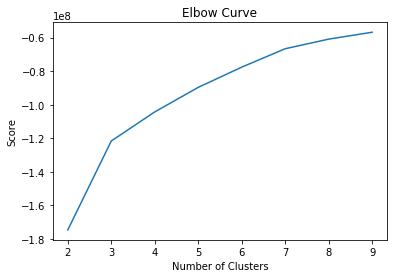

In [153]:
Nc = range(2, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [154]:
k_means_3 = KMeans(n_clusters = 3)
score_3 = k_means_3.fit(X)
df_cluster = pd.DataFrame({"cluster_3" : score_3.labels_})
df_cluster_labels = df
df_cluster_labels = pd.concat((df_cluster_labels, df_cluster), axis = 1)
df_cluster_labels['count'] = 1

In [155]:
features_of_interest = ['distracted_binary', 'age', 'sex', 
                       'dow', 'hr', 'interstate hwy', 'population class', 
                       'collision', 'injury', 'month', 'specific location',
                       'relation to road', 'intersection type', 'work zone', 
                       'speed limit', 'vehicle occupants']

In [156]:
df_cluster_labels['cluster_3'].value_counts()

2.0    186782
0.0    140928
1.0    107783
Name: cluster_3, dtype: int64

In [157]:
df_groupby = group_pct(df_cluster_labels, 'distracted_binary', "cluster_3")
df_groupby

,cluster_3,distracted_binary,count
0,0.0,0,89.420129
1,0.0,1,10.579871
2,1.0,0,89.642151
3,1.0,1,10.357849
4,2.0,0,89.422964
5,2.0,1,10.577036


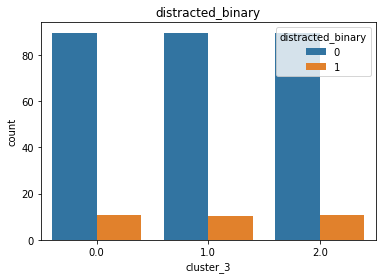

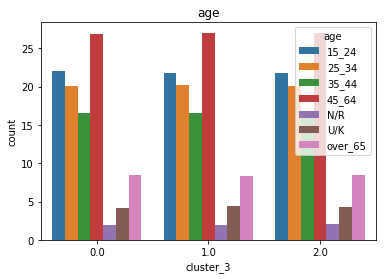

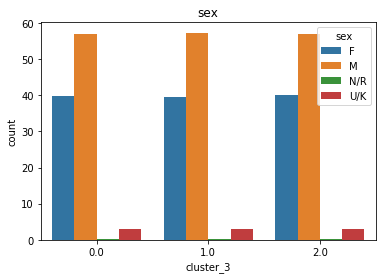

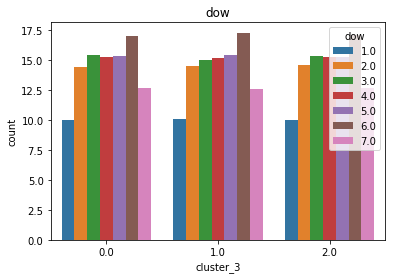

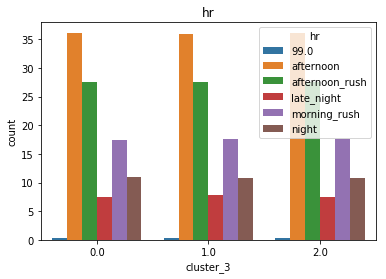

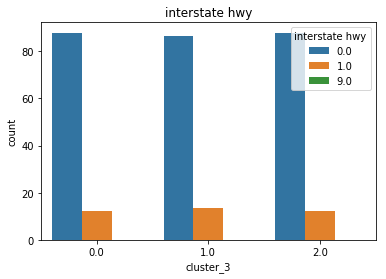

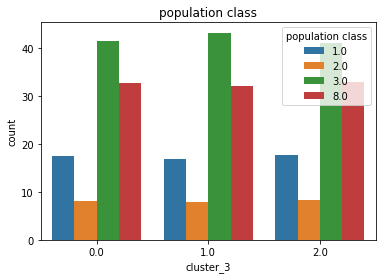

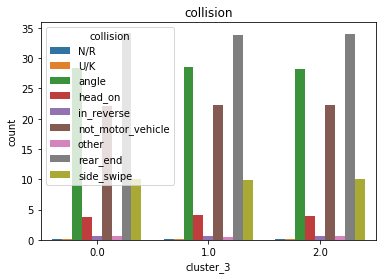

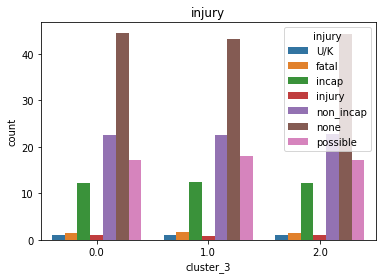

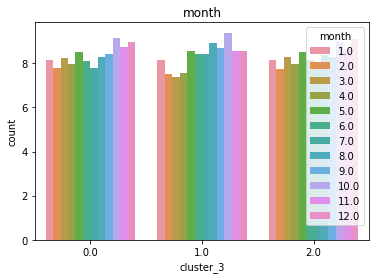

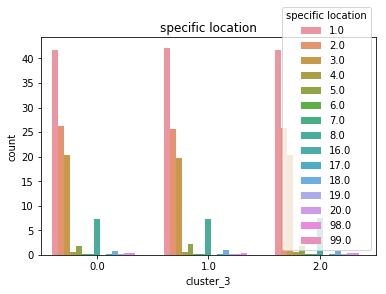

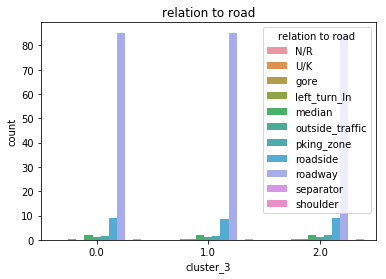

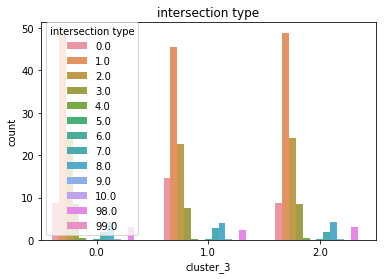

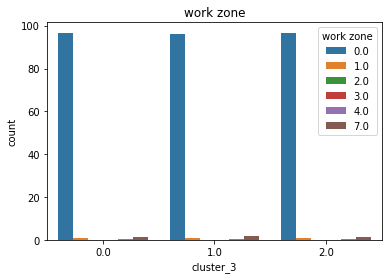

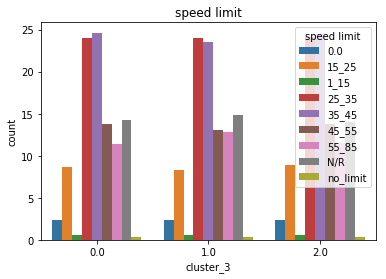

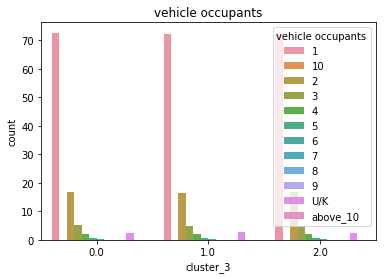

In [158]:
for feature_of_interest in features_of_interest:
    df_groupby = group_pct(df_cluster_labels, feature_of_interest, "cluster_3")
    plt.figure()
    plt.title(feature_of_interest)
    sns.barplot(x="cluster_3", y="count", hue=feature_of_interest, data=df_groupby)
    

### Future Considerations

When it comes to datasets, future considerations may be to select a more locally focused dataset. 

There are also other clustering methods that can be applied to the dataset. It may be possible to one-hot encode all categorical features, apply PCA to the dataset, and then k-means. However, as can be seen, k-modes does a good job clustering the data. 

Using the k-modes algorithm for clustering, it may be useful to try adaptive boosting in order to derive the best weightings that point to important features in distinctions across clusters. Or, more domain research may be performed to manually select more relevant features. 

Although it is difficult with the GES dataset, as there is a lack of trust in the distracted classifications and underreporting in the dataset, further analysis might involve a deeper analysis across distraction types. This could involve manual categorization of values in this variable, and then inferential statistics or EDA using the k-modes clusters obtained in this analysis. 

### Works Cited

Callaway, J. (2014). Fatal Distraction The Impact of Driver Distraction on U.S. Motor Vehicle Mortality(Rep.). Retrieved October 8, 2018, from Reinsurance Group of America website: https://www.rgare.com/docs/default-source/default-document-library/fatal-distraction.pdf?sfvrsn=596d888_0

Fischer, P. (2016). Distracted & Dangerous Helping States Keep Teens Focused on the Road(Rep.). Retrieved October 8, 2018, from Governors Highway Safety Association website: https://www.ghsa.org/sites/default/files/2016-11/TeenDistractedDriving Final 5.pdf

[NHTSA GES Dataset on Crashes]. (2016). Unpublished raw data.

Rosenberger, R. (2017, December 28). “Yes, Smartphone Use Is Probably Behind the Spike in Driving Deaths. So Why Isn’t More Being Done to Curb It?”. Slate. Retrieved October 10, 2018, from http://www.slate.com/articles/technology/future_tense/2017/12/yes_smartphone_use_is_probably_behind_the_spike_in_vehicle_related_deaths.html

Vegega, M., Jones, B., & Monk, C. (2013, December). Understanding the ffects of distracted driving and developing strategies to reduce resulting deaths and injuries: A report to congress. (Report No. DOT HS 812 053). Washington, DC: National Highway Traffic Safety Administration.
